## Method 3: Chord Classifier
This notebook contains the code for the Chord Classifier part of the combined method

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm


In [3]:
A_FREQ = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [4]:
def note_from_freq(freq):
    r = 12.0*np.log2(freq/A_FREQ)
    return r

def freq_from_note(r):
    f = A_FREQ*2**(r/12)
    return f

# gets the maximum volume of the note in the fft image for a given note within a window of frequency
def get_note_volume(note,fft_image,fft_freq,note_window=0.2):
    if isinstance(note,str):
        note = NOTES.index(note)
    try:
        f0 = freq_from_note(note-note_window)
        f1 = freq_from_note(note+note_window)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except:
        return 0
    
    return maxVol

# gets the maximum volume of the note in the fft image for a given note over all octaves
def get_notes_volume(notes,fft_image,fft_freq,oct_from=-4.,oct_to=8.):
    # if note is a string, convert to index
    if isinstance(notes,str):
        notes = NOTES.index(notes)
    
    # get the notes in the range of octaves
    notes = np.arange(notes+12.*oct_from,notes+12.*oct_to,12.0)
    vol = []

    # get the volume of each note
    for rn in notes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    # return the maximum volume of that note
    return np.max(vol)


In [5]:
def preprocess(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)

    note_vols = np.zeros(12)

    for rnote in range(12):
        note_vols[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
    
    # get the indexes of the top 3 notes
    top_notes = note_vols.argsort()[-3:][::-1]
    
    # get the differences between the top 3 notes
    diffs = []
    for i in range(len(top_notes)-1):
        diffs.append(top_notes[i] - top_notes[i+1])
    
    diffs.append(top_notes[0] - top_notes[-1])

    return diffs, note_vols
 

In [6]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [7]:
print(preprocess(train_set['File Path'].iloc[0]))
# replace all paths in train_set and test_set that have a # in it to replace the # with s
train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

([9, -1, 8], array([5.14683663e-04, 4.98163980e-04, 8.30797944e-05, 1.02320169e-04,
       1.23592006e-04, 1.07863976e-04, 3.86379659e-04, 1.89827930e-04,
       1.05026404e-04, 6.59153040e-04, 3.10034287e-04, 1.09101835e-04]))


In [8]:
# disable warnings
warnings.filterwarnings("ignore")

# add the diffs and note_vols columns to the train set, where each diff note_vol is a different column
for j in range(3):
    train_set['diff' + str(j)] = None

for k in range(12):
    train_set['note_vol' + str(k)] = None

diffs = []
note_vols = []
for i in tqdm(range(len(train_set))):
    diff, note_vol = preprocess(train_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            train_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            train_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)


  0%|          | 0/713 [00:00<?, ?it/s]

100%|██████████| 713/713 [00:04<00:00, 169.33it/s]


In [9]:
# print the head of the train_set to make sure the columns were added correctly
print(train_set.head())

                               File Path Root Note  Octave Quality  Inversion  \
0   data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim          1   
3   data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min          0   
20  data/chords/maj/Ab-3-maj-chord-1.wav        Ab       3     maj          1   
28  data/chords/aug/Ab-2-aug-chord-0.wav        Ab       2     aug          0   
32   data/chords/aug/G-4-aug-chord-1.wav         G       4     aug          1   

   diff0 diff1 diff2 note_vol0 note_vol1 note_vol2 note_vol3 note_vol4  \
0      9    -1     8  0.000515  0.000498  0.000083  0.000102  0.000124   
3     -4     7     3  0.000197  0.004805  0.000518  0.000394  0.007915   
20     8    -3     5  0.000794  0.002993  0.000608  0.028265  0.000975   
28     4     4     8  0.000913  0.001247  0.002298  0.020926  0.001299   
32    -8     4    -4  0.000572  0.001208  0.008392  0.000506  0.000611   

   note_vol5 note_vol6 note_vol7 note_vol8 note_vol9 note_vol10 note

In [10]:
for j in range(3):
    test_set['diff' + str(j)] = None

for k in range(12):
    test_set['note_vol' + str(k)] = None


for i in tqdm(range(len(test_set))):
    diff, note_vol = preprocess(test_set['File Path'].iloc[i])
    diffs.append(diff)
    note_vols.append(note_vol)

    try:
        # set the columns diff_0 to diff_2 and note_0 to note_11 at train_set index i to the values in diff and note_vol
        for j in range(3):
            test_set['diff' + str(j)].iloc[i] = diff[j]
        
        for k in range(12):
            test_set['note_vol' + str(k)].iloc[i] = note_vol[k]
    except:
        print(diff, note_vol)

100%|██████████| 307/307 [00:01<00:00, 164.93it/s]


In [11]:
print(test_set.head())

                               File Path Root Note  Octave Quality  Inversion  \
10  data/chords/aug/Cs-4-aug-chord-1.wav        C#       4     aug          1   
12   data/chords/aug/A-5-aug-chord-1.wav         A       5     aug          1   
15   data/chords/min/F-4-min-chord-2.wav         F       4     min          2   
16  data/chords/aug/Ab-7-aug-chord-0.wav        Ab       7     aug          0   
18   data/chords/dim/F-7-dim-chord-0.wav         F       7     dim          0   

   diff0 diff1 diff2 note_vol0 note_vol1 note_vol2 note_vol3 note_vol4  \
10    -8     4    -4  0.021142   0.00095  0.000786  0.001522  0.007849   
12    -4     8     4   0.00494  0.000153  0.000228  0.000305  0.006822   
15    -8     3    -5   0.00202  0.000759  0.000409  0.006797  0.000349   
16     4     4     8  0.000152  0.000205  0.000121  0.000386  0.000211   
18    -3     9     6  0.000223  0.000229   0.00034  0.000218  0.000075   

   note_vol5 note_vol6 note_vol7 note_vol8 note_vol9 note_vol10 note

In [12]:
# train a KNN to predict the quality based on the diff and note_vol columns
from sklearn.neighbors import KNeighborsClassifier

# create the KNN model
knn = KNeighborsClassifier(n_neighbors=1)

# create the X and y arrays
X = train_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion'])
y = train_set['Quality']

# fit the model
knn.fit(X, y)

# predict the quality of the test_set
predictions = knn.predict(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']))

# print the accuracy of the model
print(knn.score(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']), test_set['Quality']))


0.9185667752442996


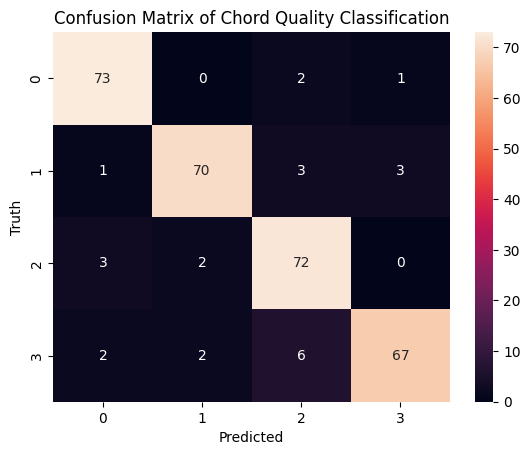

In [13]:
# plot a confusion matrix of the results
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_set['Quality'], predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix of Chord Quality Classification')
plt.show()

we have every note and the amount of that note
to get it manually we took every chord and found how much of each chord is in that note

what would be useful would be to use something like the intervals as a feature

i would imagine using the amount of each note would be useful but this has not worked in the past

what if we started with something that we know would work and then worked backwards from there

In [14]:
# try multi class logistic regression
from sklearn.linear_model import LogisticRegression

# create the logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model
logreg.fit(X, y)

# predict the quality of the test_set
predictions = logreg.predict(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']))

# print the accuracy of the model
print(logreg.score(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']), test_set['Quality']))


0.23778501628664495


In [15]:
# try a random forest
from sklearn.ensemble import RandomForestClassifier

# create the random forest model
rf = RandomForestClassifier(n_estimators=100)

# fit the model
rf.fit(X, y)

# predict the quality of the test_set
predictions = rf.predict(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']))

# print the accuracy of the model
print(rf.score(test_set.drop(columns=['Quality', 'Root Note', 'File Path', 'Inversion']), test_set['Quality']))


0.8013029315960912
